In [23]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
ROOT_DIR = "../"
sys.path.append(ROOT_DIR)
from utils.citymeta import load_all

city_fatality = load_all("fatality_data_source")
city_fatality = city_fatality[city_fatality['num_person_killed_per_lakh']!=''][['City','Region', 'num_person_killed_per_lakh']]
# city_fatality.shape

# 1. Merge city level all information

In [24]:
ROOT = "/Users/yuan/Dropbox (Personal)/Personal Work/_Projects2023"
# ROOT = "D:/Dropbox (Personal)/Personal Work/_Projects2023"
CURATED_FOLDER = f"{ROOT}/01_city-never-was/_data/_curated/"
EXPORT_FOLDER = f"{ROOT}/01_city-never-was/_data/_curated/c_analysis"
DATA_FOLDER = f"{CURATED_FOLDER}/c_seg_hex"
TRANSFORM_FOLDER = f"{ROOT}/01_city-never-was/_data/_transformed/t_city_profiles"


gdp = pd.read_csv(os.path.join(CURATED_FOLDER,"c_city_profiles", "c_city_gdp.csv"))
flux = pd.read_csv(os.path.join(TRANSFORM_FOLDER, "t_ffdas_flux_2015.csv"))
gdp['city_lower'] = gdp['City'].apply(lambda x: x.lower().replace(" ", "").split(",")[0])
profiledf = flux.merge(gdp, on = 'city_lower', how = 'inner')

waze_df = pd.read_csv(os.path.join(f"{ROOT}/01_city-never-was/_data/_curated/c_waze/","c_waze_accident_alerts_h3_9.csv"))
print(profiledf['city_lower'].nunique(), " city profiles found")
city_meta = load_all()

127  city profiles found


### Visualize the country profiles

<AxesSubplot:xlabel='gdp_per_cap_country_2022', ylabel='country_clean'>

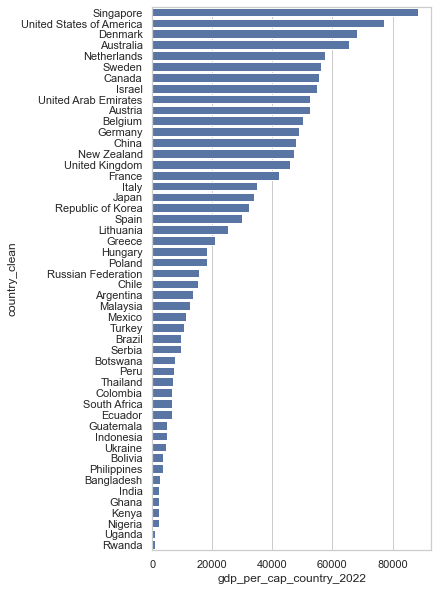

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(
    data = profiledf.drop_duplicates("country_clean").sort_values('gdp_per_cap_country_2022', ascending = False),
    y = "country_clean",
    x = 'gdp_per_cap_country_2022'
)

Text(0.5, 1.0, 'Top 30 cities by total FFDAS flux')

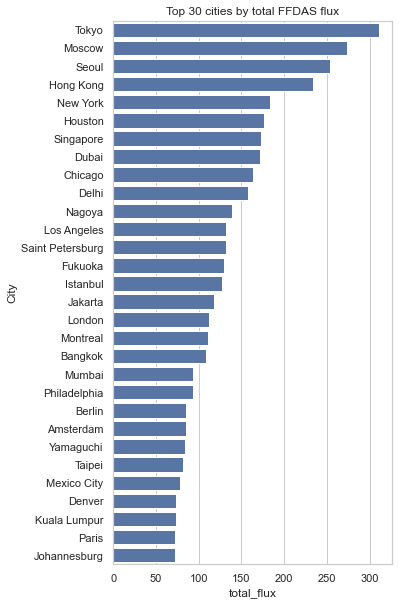

In [4]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(
    data = profiledf.sort_values('total_flux', ascending = False).head(30),
    y = "City",
    x = 'total_flux'
)
# add title
plt.title("Top 30 cities by total FFDAS flux")

In [5]:
remain = [x for x in gdp['city_lower'] if x not in profiledf['city_lower'].tolist()]
remain

[]

In [25]:
FILENAME_CROSS = "01_seg_dalys_cross.csv"
y = ['diabetes_mellitus_cap', 'mental_and_substance_use_disorders_cap',
       'cardiovascular_diseases_cap', 'road_injury_cap',
       'road_injury_5-14_cap', 'road_injury_15-29_cap',
       'num_person_killed_per_lakh']
N = 8 # 13
# cluster_df = pd.read_parquet(os.path.join(DATA_FOLDER, f"all_city_within_boundary_res=9_cluster={N}.parquet"))
withincity = True
res = 9
cluster_df = pd.read_csv(os.path.join(DATA_FOLDER, "c_seg_cat=31_res={res}_withincity_tsne_cluster={n}.csv".format(res = res, n = N)))
crossdf = pd.read_csv(os.path.join(CURATED_FOLDER, "c_analysis", FILENAME_CROSS)).drop(["urban_pop"], axis = 1)
crossdf['city_lower'] = crossdf['city_lower'].apply(lambda x: x.lower().replace(" ", "").split(",")[0])
crossdf = crossdf[crossdf['res']==9].reset_index(drop = True)

y_crossed = crossdf[y+['city_lower']].drop_duplicates()

cluster_df['city_lower'] = cluster_df['city_lower'].apply(lambda x: x.lower().replace(" ", "").split(",")[0])
# cluster_df.head()
cluster_df_summary = cluster_df.groupby(['city_lower',f'cluster_{N}']).size().reset_index(name='count')\
       .pivot(index='city_lower', columns=f'cluster_{N}', values='count').reset_index().fillna(0)
# convert to wide format
cluster_df_summary['total'] = cluster_df_summary.sum(axis=1)
for c in cluster_df_summary.columns[1:-1]:
    cluster_df_summary[c] = cluster_df_summary[c]/cluster_df_summary['total']
    cluster_df_summary.rename(columns={c: f"cluster_{c}"}, inplace=True)


/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_82780/3675797641.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  cluster_df_summary['total'] = cluster_df_summary.sum(axis=1)


In [26]:
# calculate the entropy among the eight clusters
from scipy.stats import entropy
# force the entropy to range from 0 to 1
entropy_variables = ['cluster_'+str(i) for i in range(N)]
cluster_df_summary['diversity'] = \
    cluster_df_summary[entropy_variables].apply(lambda x: entropy(x)/np.log(N), axis = 1)

In [30]:
waze_df

,city,h3_9,count
0,amsterdam,8919682588bffff,1
1,amsterdam,89196825d8bffff,1
2,amsterdam,891968265c3ffff,1
3,amsterdam,891968a5aafffff,1
4,amsterdam,89196900353ffff,1
...,...,...,...
6908,warsaw,891f53cb133ffff,2
6909,warsaw,891f53cb38bffff,1
6910,warsaw,891f53cb3c3ffff,1
6911,warsaw,891f53cb5d7ffff,1


In [32]:
waze_count_df = waze_df.groupby('city')['count'].sum().reset_index(name='waze_accident_count')
waze_count_df

,city,waze_accident_count
0,amsterdam,20
1,antwerp,159
2,auckland,1
3,belohorizonte,527
4,berlin,1
...,...,...
57,toledo,2
58,toronto,88
59,vienna,6
60,warsaw,41


In [33]:
# city level merge first
city_fatality['city_lower'] = city_fatality['City'].apply(lambda x: x.lower().replace(" ", "").split(",")[0])
city_fatality['num_person_killed_per_lakh'] = city_fatality['num_person_killed_per_lakh'].astype(float)
city_df = cluster_df_summary.merge(profiledf, on = "city_lower", how = 'left')\
       .merge(city_meta[['center_lat', 'center_lng', 'city_lower']],on = "city_lower", how = 'left' )\
       .merge(city_fatality[['city_lower', 'num_person_killed_per_lakh']],
              on = ['city_lower'], how = 'inner')\
                     .merge(y_crossed, on = 'city_lower', how = 'inner', suffixes=('_city', '_country'))\
                            .merge(waze_count_df, left_on = 'city_lower', right_on = 'city', how = 'left').drop('city', axis = 1)
city_df.to_csv(os.path.join(EXPORT_FOLDER, 
                            f"c_city_full_cluster={N}.csv"), 
               index = False)


In [48]:
waze_count_df.columns

Index(['city', 'waze_accident_count'], dtype='object')

In [38]:
waze_df.rename(columns = {'city':'city_lower','h3_9':'hex_id', 'count':'waze_accident_count'}, inplace = True)

In [51]:
city_df.columns

Index(['city_lower', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
       'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'total',
       'diversity', 'total_flux', 'mean_flux', 'flux_n_points', 'City',
       'country_clean', 'State/Province', 'urban_pop', 'Metro',
       'gdp_billion_metro', 'gdp_pop_metro', 'source_year', 'gdp_per_cap',
       'gdp_per_cap_country_2022', 'center_lat', 'center_lng',
       'num_person_killed_per_lakh_city', 'diabetes_mellitus_cap',
       'mental_and_substance_use_disorders_cap', 'cardiovascular_diseases_cap',
       'road_injury_cap', 'road_injury_5-14_cap', 'road_injury_15-29_cap',
       'num_person_killed_per_lakh_country', 'waze_accident_count'],
      dtype='object')

<AxesSubplot:xlabel='waze_accident_count', ylabel='num_person_killed_per_lakh_city'>

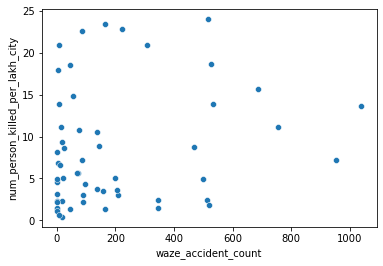

In [52]:
import seaborn as sns
sns.scatterplot(
    data = city_df,
    x = 'waze_accident_count',
    y = 'num_person_killed_per_lakh_city',
)

In [41]:
cluster_df.columns

Index(['city_lower', 'hex_id', 'img_count', 'res', 'tsne_1', 'tsne_2',
       'cluster_8'],
      dtype='object')

In [43]:
# country level merge
hex_mergedf = cluster_df.merge(profiledf, on = "city_lower", how = 'left')\
       .merge(city_fatality[['city_lower', 'num_person_killed_per_lakh']],
              on = ['city_lower'], how = 'inner')\
       .merge(crossdf, on = ['city_lower','country_clean', 'hex_id'], 
              how = 'inner', suffixes=('_city', '_country'))\
       .merge(waze_df, on = ['city_lower', 'hex_id'], 
               how = 'left')

# print(hex_mergedf['city_lower'].nunique())
# hex_mergedf.to_csv(os.path.join(EXPORT_FOLDER,
#                             f"c_hex_full_cluster={N}.csv"), index = False)

In [45]:
hex_mergedf['waze_accident_count'] = hex_mergedf['waze_accident_count'].fillna(0)

In [46]:
hex_mergedf.to_csv(os.path.join(EXPORT_FOLDER,
                            f"c_hex_full_cluster={N}.csv"), index = False)

In [47]:
hex_mergedf.head()

,city_lower,hex_id,img_count_city,res_city,tsne_1,tsne_2,cluster_8,total_flux,mean_flux,flux_n_points,...,log_bike,log_sky,log_road,log_diabetes_mellitus_cap,log_mental_and_substance_use_disorders_cap,log_cardiovascular_diseases_cap,log_road_injury_cap,log_road_injury_5-14_cap,log_road_injury_15-29_cap,waze_accident_count
0,accra,8975292c127ffff,20,9.0,27.504154,-1.704337,0,8.835611,0.883561,10,...,3.391147,11.038027,10.908840,6.654522,7.471,8.105493,7.427402,5.642771,6.2892,0.0
1,accra,8975292c803ffff,40,9.0,-46.094727,38.523640,3,8.835611,0.883561,10,...,0.000000,11.180499,10.462187,6.654522,7.471,8.105493,7.427402,5.642771,6.2892,0.0
2,accra,8975292c80bffff,80,9.0,-42.831554,31.134777,3,8.835611,0.883561,10,...,1.933331,11.193921,10.733147,6.654522,7.471,8.105493,7.427402,5.642771,6.2892,0.0
3,accra,8975292c817ffff,56,9.0,-45.625553,37.471640,3,8.835611,0.883561,10,...,1.162034,11.111033,10.548794,6.654522,7.471,8.105493,7.427402,5.642771,6.2892,0.0
4,accra,8975292c81bffff,32,9.0,-45.477470,37.168080,3,8.835611,0.883561,10,...,0.000000,11.197498,10.614861,6.654522,7.471,8.105493,7.427402,5.642771,6.2892,0.0


# data summary

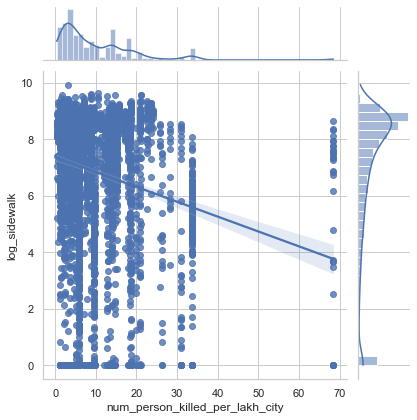

In [39]:
# describe the relationship between gdp and sidewalk
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
hex_mergedf['log_gdp_per_cap_country_2022'] = np.log(hex_mergedf['gdp_per_cap_country_2022'])
g = sns.jointplot(data = hex_mergedf[hex_mergedf['res']==6], 
                  x = 'num_person_killed_per_lakh_city', 
                  y = 'log_sidewalk', kind = 'reg')

KeyboardInterrupt: 

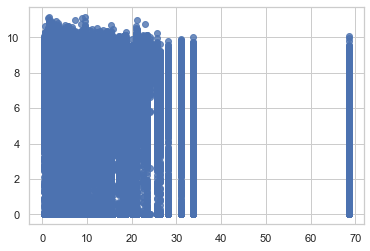

In [51]:
# g = sns.regplot(data = hex_mergedf, 
#                   x = 'num_person_killed_per_lakh_city', 
#                   y = 'log_sidewalk')
                #   hue = 'country_clean')
                #   kind = 'reg')

In [ ]:
# FILENAME_LONG = "01_seg_dalys_long_res=9.csv"
# longdf = pd.read_csv(os.path.join(CURATED_FOLDER, 
#                                   "c_analysis", 
#                                   FILENAME_LONG)).drop(["urban_pop"], axis = 1)
# longdf.columns

Index(['hex_id', 'res', 'city_lower', 'year_group', 'img_count', 'building',
       'greenery', 'street_furniture', 'sidewalk', 'car', 'person', 'bike',
       'sky', 'road', 'street_furniture_count', 'car_count', 'person_count',
       'bike_count', 'num_person_killed_per_lakh', 'num_person_killed', 'city',
       'city_clean', 'country_clean', 'pop_country', 'year',
       'diabetes_mellitus_cap', 'mental_and_substance_use_disorders_cap',
       'cardiovascular_diseases_cap', 'road_injury_cap',
       'road_injury_5-14_cap', 'road_injury_15-29_cap'],
      dtype='object')

In [ ]:
# for res in [6,9]:
#     temp = mergedf[mergedf['res'] == res].drop(['res','City'], axis = 1)
#     temp.to_csv(os.path.join(CURATED_FOLDER, "c_analysis", f"c_cross_res={res}.csv"), 
#                 index = False)

# 2. Add Hex level information